# Tanzania Water Wells

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?
- What exactly is your deliverable: your analysis, or the model itself?
- Does your business understanding/stakeholder require a specific type of model?
    - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
   

Additional questions to consider for classification:

- What does a false positive look like in this context?
- What does a false negative look like in this context?
- Which is worse for your stakeholder?
- What metric are you focusing on optimizing, given the answers to the above questions?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [9]:
#pip install category_encoders

In [2]:
#Import Utilities
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

import category_encoders as ce

In [3]:
#Find location of datasets
!ls

Data                     Notebook
MainNotebookDragon.ipynb README.md


In [4]:
!ls Data

test_set_variables.csv     training_set_variables.csv
training_set_values.csv


In [7]:
#read target variables
df_variables = pd.read_csv('Data/training_set_variables.csv')
df_variables.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
#read feature values
df_values = pd.read_csv('data/training_set_values.csv')
df_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
#Merge target and features into 1 dataframe
df = df_variables.merge(df_values, left_on='id', right_on='id')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [85]:
#Explore target values
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

#### We are only going to focus on water wells that need repair. It doesn't matter if it's functional or not. Therefore, we will combine `non functional` and `functional needs repair` into one target.

In [10]:
#Create a Target column of 0's and 1's
df['target'] = (df['status_group'] == 'functional').astype(int)

In [11]:
#Explore Target value counts
df['target'].value_counts()

1    32259
0    27141
Name: target, dtype: int64

In [12]:
#Explore Target percentages
df['target'].value_counts(normalize=True)

1    0.543081
0    0.456919
Name: target, dtype: float64

In [13]:
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [15]:
#Explore Numeric columns
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,0.543081
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.498145
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,1.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,1.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,1.000000


In [16]:
#Explore Object columns
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,status_group,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,59400,55765,55745,59400,59400,59029,59400,59400,59400,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,3,356,1897,2145,37400,9,19287,21,125,2092,...,7,8,6,5,5,10,7,3,7,6
top,functional,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,32259,572,9084,17402,3563,10248,508,5294,2503,307,...,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


In [17]:
#Number of unique values in the Object columns
df[[c for c in df.columns if df[c].dtype == 'object']].nunique().sort_values(ascending = False)

wpt_name                 37400
subvillage               19287
scheme_name               2696
installer                 2145
ward                      2092
funder                    1897
date_recorded              356
lga                        125
region                      21
extraction_type             18
extraction_type_group       13
management                  12
scheme_management           12
source                      10
basin                        9
water_quality                8
payment_type                 7
extraction_type_class        7
waterpoint_type              7
source_type                  7
payment                      7
waterpoint_type_group        6
quality_group                6
management_group             5
quantity                     5
quantity_group               5
source_class                 3
status_group                 3
public_meeting               2
permit                       2
recorded_by                  1
dtype: int64

In [18]:
df.isnull().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

#### Train Test Split

In [19]:
# Define our X and y

X = df.drop(columns=['target', 'status_group'])
y = df['target']

# and train test split - to create our val holdout set!
X_tr, X_hold, y_tr, y_hold = train_test_split(X, y, test_size=0.1, # saving 10%
                                                  random_state=42)

# and 2nd train test split - to create our test set!
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.25, # saving 25%
                                                  random_state=42)

In [20]:
#Columns that won't be used because it's not necessary
not_used_cols = ['waterpoint_type', #too similar to waterpoint_type_group
                 'subvillage', #too many unique values
                 'wpt_name', #too many unique values
                 'source_type', #too similar to source column
                 'quantity_group', #too similar to quantity
                 'water_quality', #too similar to quality group
                 'payment_type', #not needed to make a prediction on well functionality
                 'management', #too similar to management group
                 'extraction_type', #too similar to extraction type class
                 'extraction_type_group', #too similar to extraction type class
                 'scheme_name', #too many nulls
                 'region_code', #too similar to region
                 'id', #not needed to make a prediction on well functionality
                 'longitude', #too many have a 0 value and we're using region and district
                 'latitude', #too many have a 0 value and we're using region and district
                 'date_recorded', #not needed to make a prediction on well functionality
                 'payment', #not needed to make a prediction on well functionality
                 'recorded_by'] #not needed to make a prediction on well functionality

In [21]:
#Columns we will use because we think they will have an impact on our predictions
used_cols = ['amount_tsh', 
             'funder', 
             'gps_height', 
             'installer',
             'num_private',
             'basin', 
             'region', 
             'district_code', 
             'lga',
             'ward',
             'population', 
             'public_meeting', 
             'scheme_management', 
             'permit', 
             'construction_year',
             'extraction_type_class', 
             'management_group',
             'quality_group',
             'quantity',
             'source', 
             'source_class', 
             'waterpoint_type_group']

In [23]:
X_train_used_cols = X_train[used_cols]
X_test_used_cols = X_test[used_cols]

In [24]:
X_train_used_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40095 entries, 39528 to 47473
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             40095 non-null  float64
 1   funder                 37612 non-null  object 
 2   gps_height             40095 non-null  int64  
 3   installer              37598 non-null  object 
 4   wpt_name               40095 non-null  object 
 5   num_private            40095 non-null  int64  
 6   basin                  40095 non-null  object 
 7   subvillage             39853 non-null  object 
 8   region                 40095 non-null  object 
 9   district_code          40095 non-null  int64  
 10  lga                    40095 non-null  object 
 11  ward                   40095 non-null  object 
 12  population             40095 non-null  int64  
 13  public_meeting         37862 non-null  object 
 14  scheme_management      37480 non-null  object 
 15

#### Split up used columns by category and number of unique values

Source for code: <br> https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb

In [25]:
# Set up lists for columns requiring different treatment
num_cols = []
ohe_cols = []
freq_cols = []

for c in X_train_used_cols.columns:
    if X_train_used_cols[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X_train_used_cols[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [26]:
print("NUMBER COLUMNS")
print(num_cols)
print('*'*10)
print("OHE COLUMNS")
print(ohe_cols)
print('*'*10)
print("FREQ COLUMNS")
print(freq_cols)

NUMBER COLUMNS
['amount_tsh', 'gps_height', 'num_private', 'district_code', 'population', 'construction_year']
**********
OHE COLUMNS
['basin', 'public_meeting', 'permit', 'extraction_type_class', 'management_group', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']
**********
FREQ COLUMNS
['funder', 'installer', 'wpt_name', 'subvillage', 'region', 'lga', 'ward', 'scheme_management', 'source']


In [27]:
print(X_train['public_meeting'].value_counts())
print(X_train['permit'].value_counts())

True     34442
False     3420
Name: public_meeting, dtype: int64
True     26216
False    11770
Name: permit, dtype: int64


In [28]:
#Create a list of boolean columns and remove from ohe_cols
#This will help with the simple imputer
bool_cols=['public_meeting','permit']
ohe_cols.remove('public_meeting')
ohe_cols.remove('permit')
print(ohe_cols)

['basin', 'extraction_type_class', 'management_group', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']


#### Create a Pipeline for each list of columns. Use an Simple Imputer to deal with null values. Then use a One Hot Encoder and Count Encoder to convert categorical columns to numerical columns

In [29]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ])

bool_transformer = Pipeline(steps=[
    ('bool_imputer', SimpleImputer(strategy='constant', fill_value=False)),
    ('bool_encoder', OneHotEncoder(handle_unknown='error', drop='first'))
])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='error', drop='first'))
])

freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05))
])

In [30]:
# Package those pieces together using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('bool', bool_transformer, bool_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [31]:
preprocessor.fit(X_train_used_cols)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['amount_tsh', 'gps_height', 'num_private',
                                  'district_code', 'population',
                                  'construction_year']),
                                ('bool',
                                 Pipeline(steps=[('bool_imputer',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant')),
                                                 ('bool_encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['public_mee...
                                  'management_group', 'quality_group',
                                  'quantity', 'source_class',
   

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [32]:
y_train.value_counts()

1    21857
0    18238
Name: target, dtype: int64

In [33]:
y_train.value_counts(normalize=True)

1    0.54513
0    0.45487
Name: target, dtype: float64

### First Subpar Model 

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [37]:
# Create a pipeline for default Desicion Tree Classifier
pipe_dtc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier(random_state=42))
])

In [38]:
#Cross validate on y_train
cv = cross_validate(pipe_dtc, X_train_used_cols, y_train, return_train_score=True, \
                    scoring=['accuracy', 'precision','roc_auc'])
cv

{'fit_time': array([0.98522711, 0.98097801, 0.92833495, 1.00756407, 0.98959088]),
 'score_time': array([0.30234122, 0.29195118, 0.29777598, 0.36136889, 0.30339408]),
 'test_accuracy': array([0.75869809, 0.73650081, 0.75321112, 0.74423245, 0.7655568 ]),
 'train_accuracy': array([0.97758449, 0.97883153, 0.97739743, 0.97839506, 0.97833271]),
 'test_precision': array([0.77833638, 0.76182746, 0.78395062, 0.77082847, 0.79456265]),
 'train_precision': array([0.9861973 , 0.98651074, 0.98557274, 0.98486948, 0.98486774]),
 'test_roc_auc': array([0.76753069, 0.74408297, 0.76100511, 0.75356413, 0.77518432]),
 'train_roc_auc': array([0.99883835, 0.99896472, 0.99880208, 0.99889297, 0.99889847])}

In [39]:
#Fit the Decision Tree Classifier on X_train_used_cols and y_train
pipe_dtc.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [40]:
#Make predictions for model
train_preds = pipe_dtc.predict(X_train_used_cols)
train_probas = pipe_dtc.predict_proba(X_train_used_cols)[:,1]
test_preds = pipe_dtc.predict(X_test_used_cols)
test_probas = pipe_dtc.predict_proba(X_test_used_cols)[:,1]

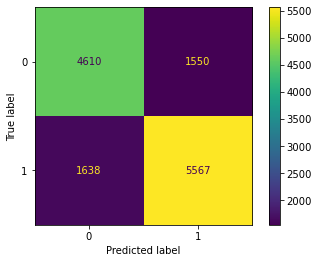

In [41]:
#Visualize Confusion Matrix
plot_confusion_matrix(pipe_dtc, X_test_used_cols, y_test)

In [42]:
# Evaluate Train and Test Scores
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.9769297917446066
Train Precision: 0.9852109411219286
Train Recall: 0.972274328590383
Train F1-Score: 0.9786998871669698
Train Roc-Auc Score: 0.998758226862588
---------------
Test Scores:
Test Accuracy: 0.7614665170220726
Test Precision: 0.7822116060137698
Test Recall: 0.7726578764746703
Test F1-Score: 0.777405390308616
Test Roc-Auc Score: 0.7693124588804672


#### This model is better than our baseline understanding but it is heavily overfitting to the training data. 

## Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

#### Since the Decision Tree Classifier was overfitting, Let's try a Random Forest

In [44]:
#Instantiate a Random Forest Classifier inside this new pipeline
pipe_rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [45]:
#Cross Validate on X_train_used_cols and y_train
cross_validate(pipe_rfc, X_train_used_cols, y_train, return_train_score=True, \
               scoring=['accuracy', 'precision','roc_auc'])

{'fit_time': array([5.10538983, 5.03203893, 4.67387795, 4.78307819, 5.19955206]),
 'score_time': array([0.75973392, 0.64378905, 0.70036316, 0.68206072, 0.76901102]),
 'test_accuracy': array([0.81207133, 0.79822921, 0.80409029, 0.80384088, 0.810949  ]),
 'train_accuracy': array([0.97745978, 0.97880035, 0.97733508, 0.97839506, 0.97833271]),
 'test_precision': array([0.81009095, 0.80034912, 0.80198447, 0.80563442, 0.81370826]),
 'train_precision': array([0.97484562, 0.97619857, 0.97564852, 0.97574796, 0.97504527]),
 'test_roc_auc': array([0.88148949, 0.87080889, 0.87987902, 0.87736411, 0.88112518]),
 'train_roc_auc': array([0.99768974, 0.99784977, 0.99753097, 0.99768208, 0.99787712])}

In [46]:
#Fit the Model to X_train_used_cols and y_train
pipe_rfc.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [47]:
#Make predictions with this model
train_preds = pipe_rfc.predict(X_train_used_cols)
train_probas = pipe_rfc.predict_proba(X_train_used_cols)[:,1]
test_preds = pipe_rfc.predict(X_test_used_cols)
test_probas = pipe_rfc.predict_proba(X_test_used_cols)[:,1]

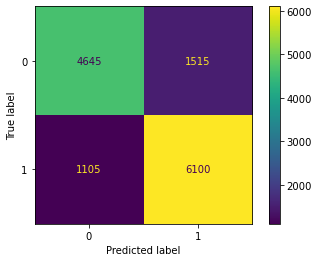

In [48]:
#Visualize Confusion Matrix
plot_confusion_matrix(pipe_rfc, X_test_used_cols, y_test)

In [49]:
#Evaluate our Random Forest Model
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.9769297917446066
Train Precision: 0.9740036231884058
Train Recall: 0.9839410715102713
Train F1-Score: 0.9789471288435715
Train Roc-Auc Score: 0.9975042154970131
---------------
Test Scores:
Test Accuracy: 0.8039655817433595
Test Precision: 0.8010505581089954
Test Recall: 0.8466342817487855
Test F1-Score: 0.8232118758434547
Test Roc-Auc Score: 0.8820729764683617


#### Even though our Precision score imporved, our Random Forest Model is still heavily overfitting. Let's try a Grid Search to tune the hyperparameters.

In [50]:
#Create a Parameter Grid
param_grid_rfc = {
    "rfc__n_estimators": [25, 50, 75],
    "rfc__max_depth" :[25, 50, 100],
    "rfc__min_samples_leaf" : [15, 25, 50],
    "rfc__class_weight" :['balanced'],
    "rfc__random_state":[42]
}

In [52]:
#Create a Grid Search for Cross Validating
#Our main scoring value is Precision because we want to decrease the False Positives
grid_rfc = GridSearchCV(estimator = pipe_rfc, param_grid=param_grid_rfc, scoring='precision')

In [53]:
#Fit the Grid Search on X_train_used_cols and y_train
grid_rfc.fit(X_train_used_cols, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'num_private',
                                                                          'district_code',
                                                                          'population',
                                                                          'construction_year']),
                                                                        ('bool',
          

In [54]:
#Visualize the results from the Grid Search
pd.DataFrame(grid_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__class_weight,param_rfc__max_depth,param_rfc__min_samples_leaf,param_rfc__n_estimators,param_rfc__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.597504,0.066381,0.197651,0.031393,balanced,25,15,25,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.789907,0.782037,0.779675,0.777730,0.780760,0.782022,0.004188,9
1,2.159071,0.083134,0.222124,0.027199,balanced,25,15,50,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.789802,0.779668,0.786899,0.777181,0.784233,0.783557,0.004613,6
2,3.051998,0.171755,0.243974,0.034504,balanced,25,15,75,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.793363,0.778228,0.785119,0.779712,0.784233,0.784131,0.005303,1
3,1.421642,0.039441,0.211962,0.038969,balanced,25,25,25,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.783955,0.766016,0.785730,0.773930,0.771645,0.776255,0.007491,16
4,2.046401,0.047580,0.218717,0.019314,balanced,25,25,50,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.781473,0.774711,0.783369,0.769623,0.778825,0.777600,0.004935,10
5,2.845618,0.134380,0.228998,0.012432,balanced,25,25,75,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.783679,0.775144,0.781869,0.767853,0.773704,0.776450,0.005741,15
6,1.481555,0.107555,0.178827,0.025812,balanced,25,50,25,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.773330,0.768003,0.766025,0.754797,0.761127,0.764657,0.006292,25
7,2.057349,0.073171,0.205529,0.023339,balanced,25,50,50,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.773610,0.764418,0.771956,0.753972,0.763005,0.765392,0.007038,19
8,2.635720,0.037422,0.218833,0.030692,balanced,25,50,75,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.770924,0.762208,0.773638,0.755007,0.761864,0.764728,0.006735,22
9,1.403452,0.060253,0.177140,0.021941,balanced,50,15,25,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",0.789417,0.781471,0.782339,0.779291,0.780801,0.782664,0.003521,7


In [55]:
#Get the best parameters from the Grid Search
grid_rfc.best_params_

{'rfc__class_weight': 'balanced',
 'rfc__max_depth': 25,
 'rfc__min_samples_leaf': 15,
 'rfc__n_estimators': 75,
 'rfc__random_state': 42}

In [56]:
#Do a Cross Validation with just the best hyperparameters
cross_validate(grid_rfc.best_estimator_, X_train_used_cols, y_train, return_train_score=True,
              scoring=['accuracy', 'precision','roc_auc'])

{'fit_time': array([3.28144288, 3.1701479 , 3.29014993, 3.06168604, 3.01553011]),
 'score_time': array([0.50624514, 0.45603728, 0.51517487, 0.52746987, 0.58344698]),
 'test_accuracy': array([0.79448809, 0.78002245, 0.78750468, 0.77939893, 0.78301534]),
 'train_accuracy': array([0.81980297, 0.82207881, 0.81977179, 0.81805711, 0.81724654]),
 'test_precision': array([0.7933635 , 0.77822839, 0.78511867, 0.77971201, 0.78423326]),
 'train_precision': array([0.81789051, 0.82326143, 0.82024624, 0.82018581, 0.8176551 ]),
 'test_roc_auc': array([0.87139711, 0.86362961, 0.86480829, 0.86325364, 0.86455856]),
 'train_roc_auc': array([0.90329618, 0.90400214, 0.90298778, 0.90141052, 0.90140729])}

In [58]:
#Fit Best Estimator on X_train_used_cols
grid_rfc.best_estimator_.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [59]:
#Make predictions for model
train_preds = grid_rfc.best_estimator_.predict(X_train_used_cols)
train_probas = grid_rfc.best_estimator_.predict_proba(X_train_used_cols)[:,1]
test_preds = grid_rfc.best_estimator_.predict(X_test_used_cols)
test_probas = grid_rfc.best_estimator_.predict_proba(X_test_used_cols)[:,1]

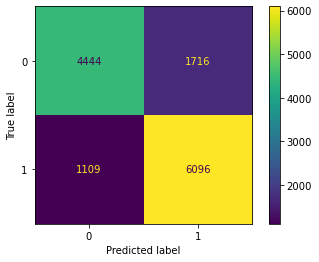

In [60]:
#Visualize Confusion Matrix
plot_confusion_matrix(grid_rfc.best_estimator_, X_test_used_cols, y_test)

In [61]:
#Evaluate the Metrics
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.821224591594962
Train Precision: 0.8206225171345004
Train Recall: 0.8600448368943587
Train F1-Score: 0.8398713251720131
Train Roc-Auc Score: 0.904541331151864
---------------
Test Scores:
Test Accuracy: 0.788627010849233
Test Precision: 0.7803379416282642
Test Recall: 0.8460791117279667
Test F1-Score: 0.8118798694812545
Test Roc-Auc Score: 0.8713590512540894


### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

#### Feature Importance

In [ ]:
# code here for visualizing feature importance

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
